In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 5)

In [25]:
INPUT_PATH = "housing_data.csv"        
OUTPUT_CLEAN = "housing_data_cleaned.csv"
PLOT_DIR = "eda_plots"
os.makedirs(PLOT_DIR, exist_ok=True)

DROP_THRESHOLD = 50.0   
MEDIAN_THRESHOLD = 30.0 

In [26]:
def save_fig(fig, name):
    path = os.path.join(PLOT_DIR, name)
    fig.savefig(path, bbox_inches="tight", dpi=150)
    plt.close(fig)

def summarize_missing(df, top_n=20):
    miss = df.isnull().sum()
    pct = (miss / len(df) * 100).round(2)
    return pd.DataFrame({"missing_count": miss, "missing_pct": pct, "dtype": df.dtypes.astype(str)}).sort_values("missing_pct", ascending=False).head(top_n)


In [27]:
df = pd.read_csv(INPUT_PATH)
print("Loaded dataset:", INPUT_PATH)
print("Shape:", df.shape)
print("\nColumns sample:")
print(df.columns[:20].tolist())
display_head = df.head()
print("\nFirst 5 rows:\n", display_head)

print("\nDataFrame info:")
print(df.info())

Loaded dataset: housing_data.csv
Shape: (1460, 81)

Columns sample:
['Unnamed: 0', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt']

First 5 rows:
    Unnamed: 0 MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0           0       SC60       RL           65     8450   Pave   NaN      Reg   
1           1       SC20       RL           80     9600   Pave   NaN      Reg   
2           2       SC60       RL           68    11250   Pave   NaN      IR1   
3           3       SC70       RL           60     9550   Pave   NaN      IR1   
4           4       SC60       RL           84    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     No    No          No       0    Feb   
1 

In [28]:
MSSubClass_map = {
    20: "1-STORY 1946 & NEWER ALL STYLES",
    30: "1-STORY 1945 & OLDER",
    40: "1-STORY W/FINISHED ATTIC ALL AGES",
    45: "1-1/2 STORY - UNFINISHED ALL AGES",
    50: "1-1/2 STORY FINISHED ALL AGES",
    60: "2-STORY 1946 & NEWER",
    70: "2-STORY 1945 & OLDER",
    75: "2-1/2 STORY ALL AGES",
    80: "SPLIT OR MULTI-LEVEL",
    85: "SPLIT FOYER",
    90: "DUPLEX - ALL STYLES AND AGES",
    120: "1-STORY PUD 1946 & NEWER",
    150: "1-1/2 STORY PUD",
    160: "2-STORY PUD 1946 & NEWER",
    180: "PUD - MULTILEVEL",
    190: "2 FAMILY CONVERSION"}

MSZoning_map = {
    'A': 'Agriculture',
    'C': 'Commercial',
    'FV': 'Floating Village Residential',
    'I': 'Industrial',
    'RH': 'Residential High Density',
    'RL': 'Residential Low Density',
    'RP': 'Residential Low Density Park',
    'RM': 'Residential Medium Density'}

if 'MSSubClass' in df.columns:
    
    try:
        df['MSSubClass'] = pd.to_numeric(df['MSSubClass'], errors='coerce').astype('Int64')
    except Exception:
        pass
   
    df['MSSubClass_desc'] = df['MSSubClass'].map(MSSubClass_map).fillna(df['MSSubClass'].astype(str))

if 'MSZoning' in df.columns:
    df['MSZoning_desc'] = df['MSZoning'].map(MSZoning_map).fillna(df['MSZoning'].astype(str))


In [29]:
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip().replace({'': np.nan, 'nan': np.nan})

for c in df.select_dtypes(include='object').columns:
 
    s = df[c].dropna().astype(str).head(500)
    if len(s) > 0:
        numeric_like = s.apply(lambda x: x.replace(',', '').replace('.', '').lstrip('+-').isdigit()).mean()
        if numeric_like > 0.9:
            df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', ''), errors='coerce')
            print(f"Converted column to numeric: {c}")

# Missing values handling 
print("\nMissing value summary (top 30):")
print(summarize_missing(df, top_n=30).to_string())

dropped_cols = []
imputed_cols = []
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

for col in df.columns.tolist():
    pct = df[col].isnull().mean() * 100
    if pct >= DROP_THRESHOLD:
        df.drop(columns=[col], inplace=True)
        dropped_cols.append((col, round(pct,2)))
        continue
    if pct >= MEDIAN_THRESHOLD:
   
        if col in numeric_cols:
            med = df[col].median()
            df[col].fillna(med, inplace=True)
            imputed_cols.append((col, 'median', round(pct,2)))
        else:
            mode = df[col].mode()
            if len(mode) > 0:
                df[col].fillna(mode[0], inplace=True)
                imputed_cols.append((col, 'mode', round(pct,2)))
            else:
                df.drop(columns=[col], inplace=True)
                dropped_cols.append((col, round(pct,2)))
    elif pct > 0:
        
        if col in numeric_cols:
            meanv = df[col].mean()
            df[col].fillna(meanv, inplace=True)
            imputed_cols.append((col, 'mean', round(pct,2)))
        else:
            mode = df[col].mode()
            if len(mode) > 0:
                df[col].fillna(mode[0], inplace=True)
                imputed_cols.append((col, 'mode', round(pct,2)))
            else:
                df.drop(columns=[col], inplace=True)
                dropped_cols.append((col, round(pct,2)))

print("\nDropped columns count:", len(dropped_cols))
if dropped_cols:
    print("Dropped sample:", dropped_cols[:10])
print("Imputed columns sample:", imputed_cols[:10])


Missing value summary (top 30):
                 missing_count  missing_pct    dtype
MSSubClass                1460       100.00    Int64
Alley                     1369        93.77   object
MasVnrType                 872        59.73   object
GarageYrBlt                 81         5.55  float64
Electrical                   1         0.07   object
KitchenQual                  0         0.00   object
GarageFinish                 0         0.00   object
GarageType                   0         0.00   object
FireplaceQu                  0         0.00   object
Fireplaces                   0         0.00    int64
Functional                   0         0.00   object
TotRmsAbvGrd                 0         0.00    int64
KitchenAbvGr                 0         0.00    int64
GarageArea                   0         0.00    int64
BedroomAbvGr                 0         0.00    int64
HalfBath                     0         0.00    int64
FullBath                     0         0.00    int64
BsmtHalfBath 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12840\425995580.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode[0], inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12840\425995580.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [30]:
# Remove duplicates
dups = df.duplicated().sum()
print("\nDuplicate rows before:", dups)
if dups > 0:
    df = df.drop_duplicates().reset_index(drop=True)
print("Shape after duplicate removal:", df.shape)

for c in ['YrSold', 'MoSold']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')

def cap_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower=lower, upper=upper)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
  
    try:
        df[col] = cap_iqr(df[col])
    except Exception:
        pass

df.to_csv(OUTPUT_CLEAN, index=False)
print("\nCleaned data saved to:", OUTPUT_CLEAN)


Duplicate rows before: 0
Shape after duplicate removal: (1460, 80)

Cleaned data saved to: housing_data_cleaned.csv


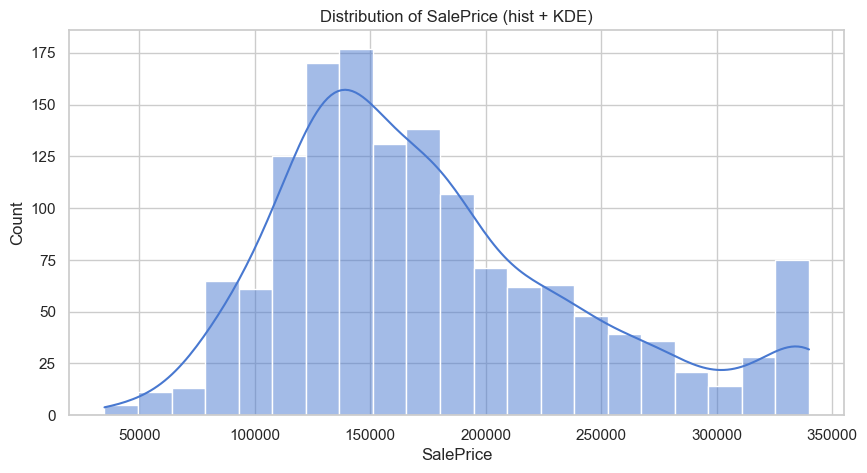

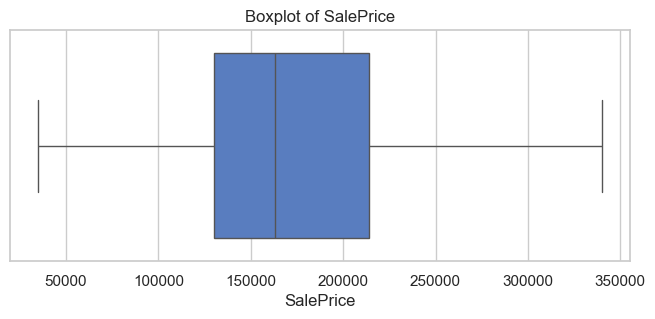

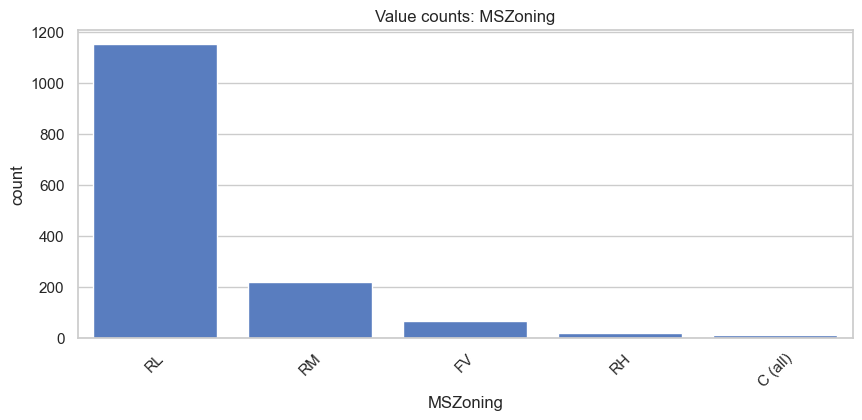

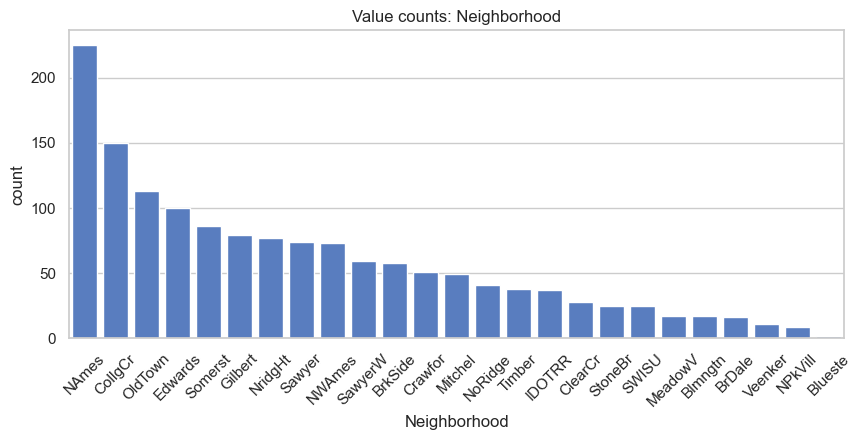

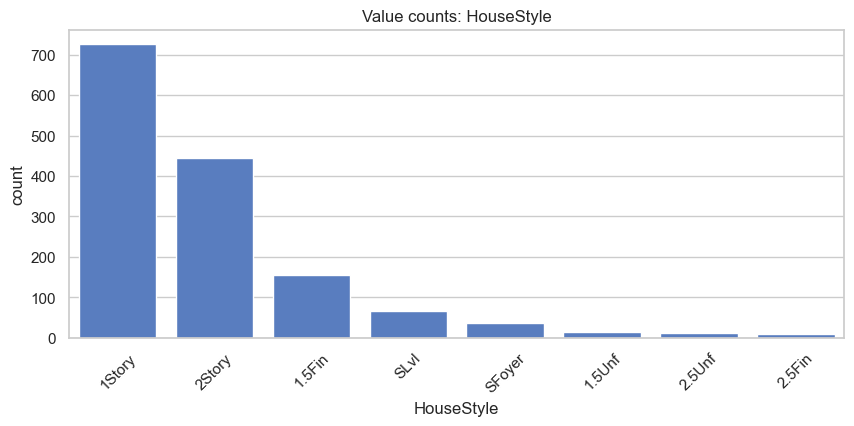

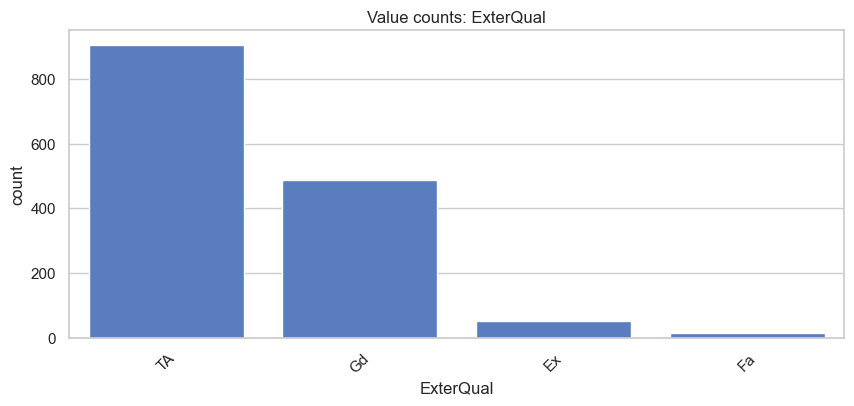

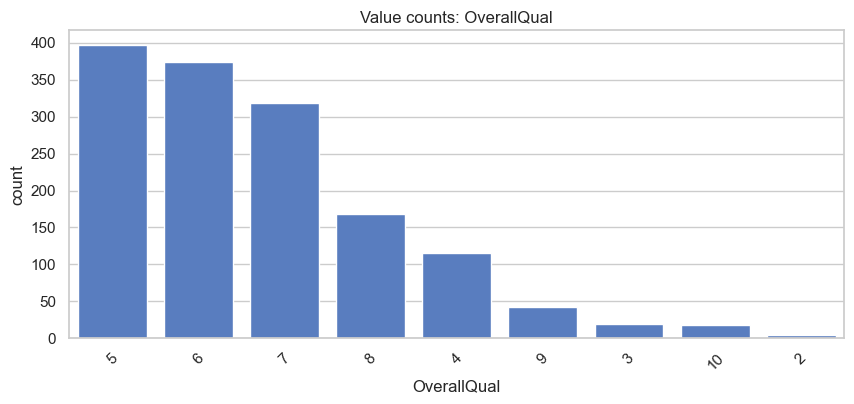

In [31]:
# Univariate Analysis 

target = 'SalePrice'
if target in df.columns:
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(df[target], kde=True, ax=ax)
    ax.set_title('Distribution of SalePrice (hist + KDE)')
    plt.show()
    save_fig(fig, "univariate_saleprice_hist_kde.png")

    fig2, ax2 = plt.subplots(figsize=(8,3))
    sns.boxplot(x=df[target], orient='h', ax=ax2)
    ax2.set_title('Boxplot of SalePrice')
    plt.show()
    save_fig(fig2, "univariate_saleprice_box.png")

cat_sample = ['MSZoning','Neighborhood','HouseStyle','ExterQual','OverallQual']
for c in cat_sample:
    if c in df.columns:
        fig, ax = plt.subplots(figsize=(10,4))
        order = df[c].value_counts().index
        sns.countplot(data=df, x=c, order=order, ax=ax)
        ax.set_title(f"Value counts: {c}")
        plt.xticks(rotation=45)
        plt.show()
        save_fig(fig, f"univariate_count_{c}.png")

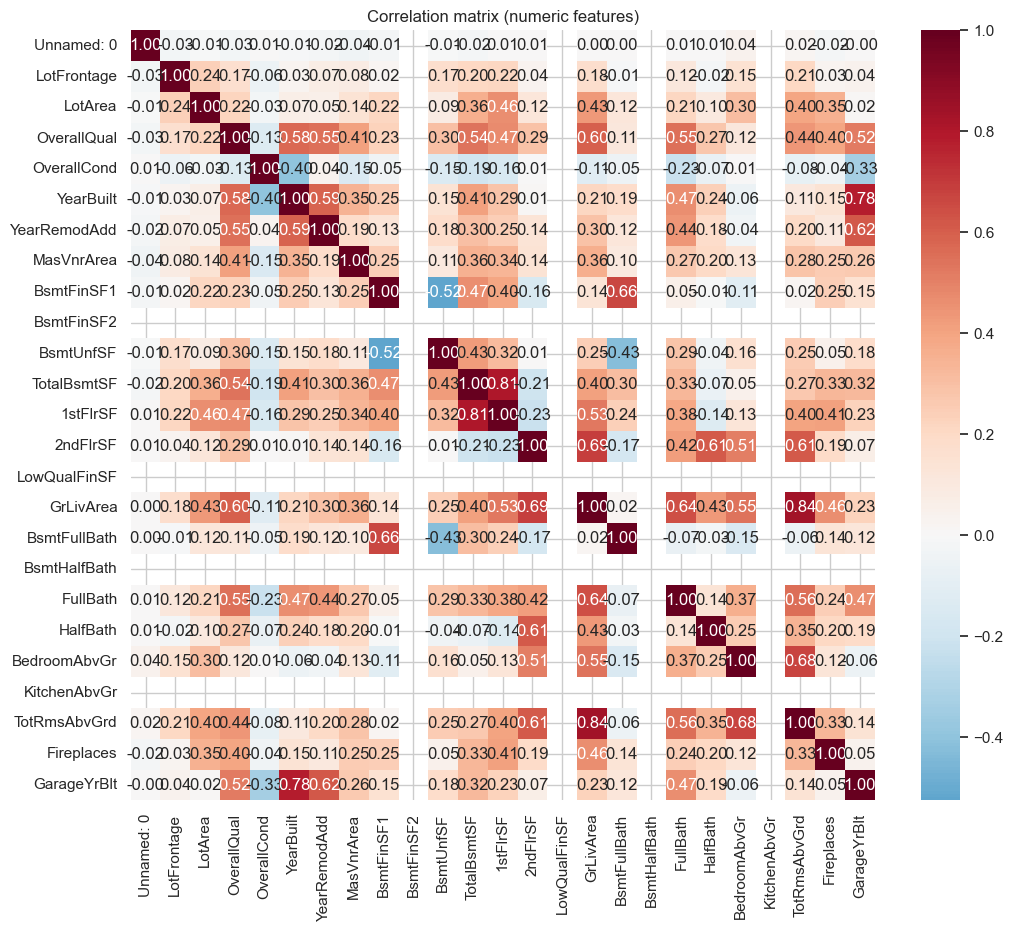

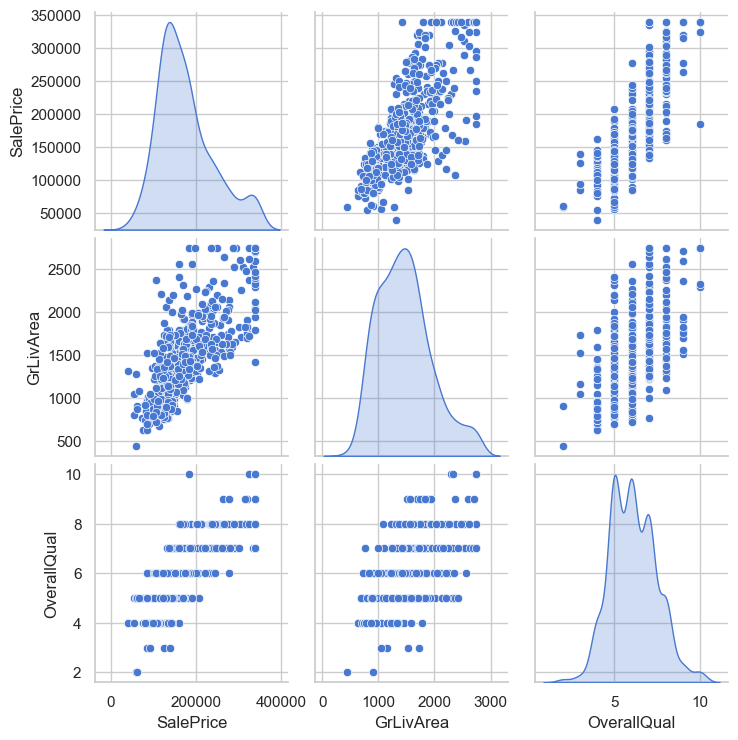

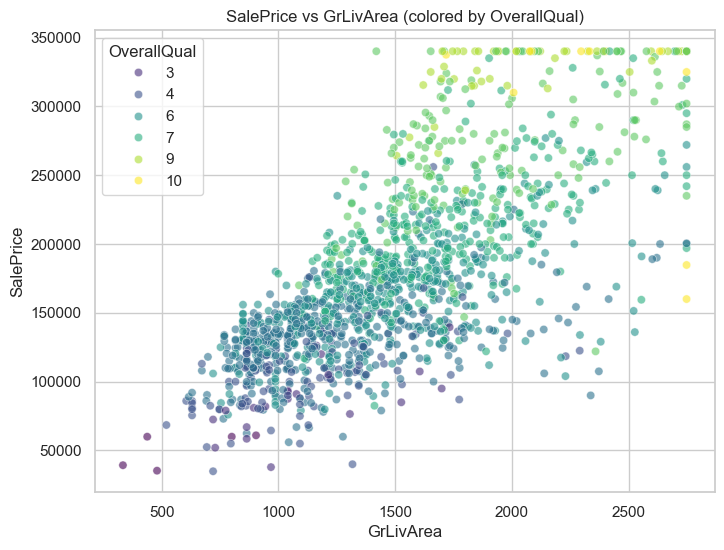

In [32]:
# Multivariate Analysis

num_for_corr = df.select_dtypes(include=[np.number]).columns.tolist()
num_for_corr = num_for_corr[:25] if len(num_for_corr) > 25 else num_for_corr
if len(num_for_corr) >= 2:
    corr = df[num_for_corr].corr()
    fig, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax)
    ax.set_title("Correlation matrix (numeric features)")
    plt.show()
    save_fig(fig, "multivariate_corr_matrix.png")

pair_features = ['GrLivArea', 'TotalBsmtSF'] if all(x in df.columns for x in ['GrLivArea','TotalBsmtSF']) else []
if 'SalePrice' in df.columns and 'GrLivArea' in df.columns:
    pair_features = ['SalePrice', 'GrLivArea', 'OverallQual']
if pair_features:
    try:
        sns.pairplot(df[pair_features].sample(min(500, len(df))), diag_kind='kde')
        plt.savefig(os.path.join(PLOT_DIR, "multivariate_pairplot.png"), bbox_inches="tight", dpi=150)
        plt.show()
        plt.close()
    except Exception as e:
        print("Pairplot failed:", e)

if 'SalePrice' in df.columns and 'GrLivArea' in df.columns:
    fig, ax = plt.subplots(figsize=(8,6))
    sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallQual' if 'OverallQual' in df.columns else None, data=df, palette='viridis', alpha=0.6)
    ax.set_title('SalePrice vs GrLivArea (colored by OverallQual)')
    plt.show()
    save_fig(fig, "multivariate_scatter_price_vs_grlivarea.png")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12840\293540051.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_per_sqft'].fillna(df['price_per_sqft'].median(), inplace=True)


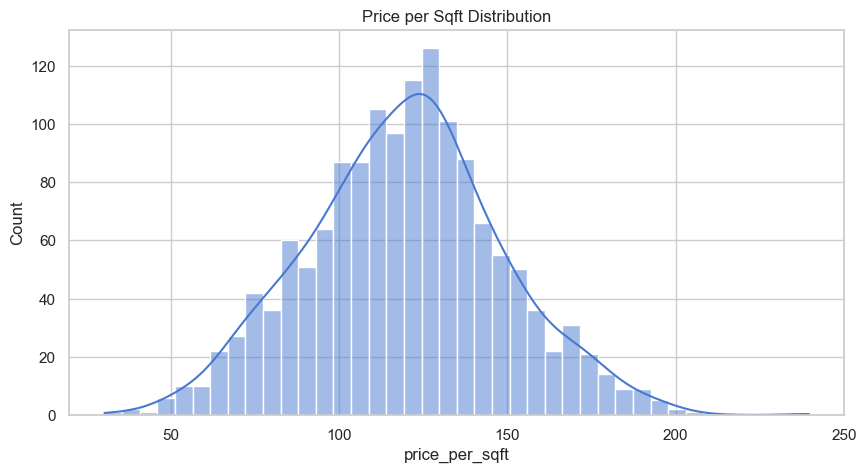


Saved feature-engineered cleaned data to: housing_data_cleaned.csv


In [33]:
#  Feature Engineering 

if 'SalePrice' in df.columns and 'GrLivArea' in df.columns:
    df['price_per_sqft'] = df['SalePrice'] / df['GrLivArea'].replace({0: np.nan})
    df['price_per_sqft'] = df['price_per_sqft'].fillna(df['price_per_sqft'].median())

if 'YrSold' in df.columns and 'YearBuilt' in df.columns:
    df['property_age'] = df['YrSold'] - df['YearBuilt']

bath_cols = []
if 'BsmtFullBath' in df.columns and 'BsmtHalfBath' in df.columns and 'FullBath' in df.columns and 'HalfBath' in df.columns:
    df['total_bathrooms'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
    bath_cols = ['total_bathrooms']

if 'GrLivArea' in df.columns and 'TotalBsmtSF' in df.columns:
    df['total_living_area'] = df['GrLivArea'] + df['TotalBsmtSF']

if 'Bedroom' in df.columns and 'total_bathrooms' in df.columns:
    df['beds_plus_baths'] = df['Bedroom'] + df['total_bathrooms']

df['price_per_sqft'] = df['SalePrice'] / df['GrLivArea'].replace({0: np.nan})
df['price_per_sqft'].fillna(df['price_per_sqft'].median(), inplace=True)
df['property_age'] = df['YrSold'] - df['YearBuilt']
df['total_bathrooms'] = (df.get('FullBath',0) + 0.5*df.get('HalfBath',0)
                         + df.get('BsmtFullBath',0) + 0.5*df.get('BsmtHalfBath',0))
sns.histplot(df['price_per_sqft'], bins=40, kde=True)
plt.title('Price per Sqft Distribution')
plt.show()

df.to_csv(OUTPUT_CLEAN, index=False)
print("\nSaved feature-engineered cleaned data to:", OUTPUT_CLEAN)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12840\2943725184.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('grliv_bin')['SalePrice'].median().reset_index().sort_values('SalePrice', ascending=False)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12840\2943725184.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')



Median SalePrice by GrLivArea bins:
             grliv_bin  SalePrice
5  (1958.0, 2747.625]   259500.0
4  (1664.667, 1958.0]   199950.0
3  (1464.0, 1664.667]   180500.0
2  (1242.667, 1464.0]   161250.0
1  (1026.0, 1242.667]   139000.0
0   (333.999, 1026.0]   118500.0


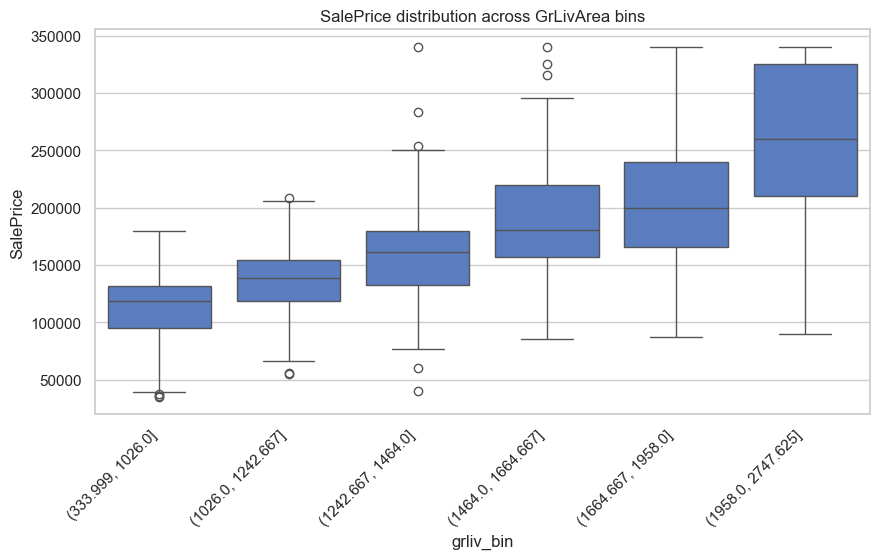

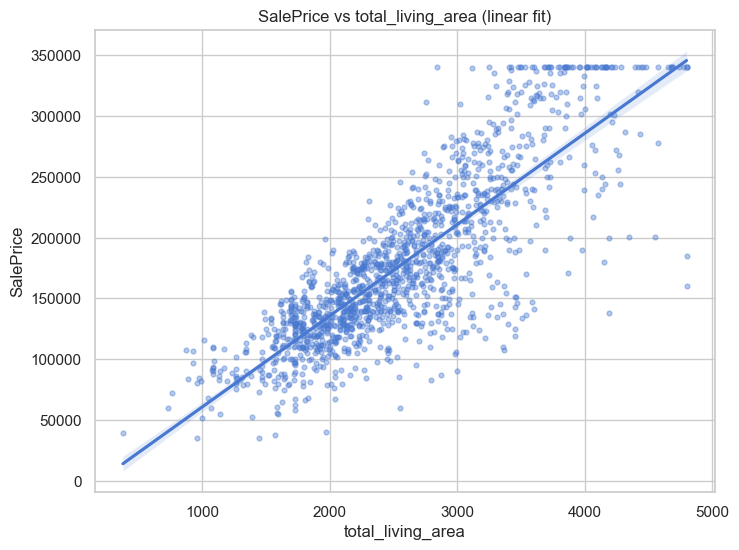

In [34]:
#  Feature Engineering and Size Impact 

if 'SalePrice' in df.columns:
   
    if 'GrLivArea' in df.columns:
        df['grliv_bin'] = pd.qcut(df['GrLivArea'], q=6, duplicates='drop')
        grp = df.groupby('grliv_bin')['SalePrice'].median().reset_index().sort_values('SalePrice', ascending=False)
        print("\nMedian SalePrice by GrLivArea bins:\n", grp.to_string())
        plt.show()
        fig, ax = plt.subplots(figsize=(10,5))
        sns.boxplot(x='grliv_bin', y='SalePrice', data=df)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_title('SalePrice distribution across GrLivArea bins')
        plt.show()
        save_fig(fig, "sizeimpact_boxplot_grlivarea_bins.png")

    if 'total_living_area' in df.columns:
        fig, ax = plt.subplots(figsize=(8,6))
        sns.regplot(x='total_living_area', y='SalePrice', data=df, scatter_kws={'s':12, 'alpha':0.4})
        ax.set_title('SalePrice vs total_living_area (linear fit)')
        plt.show()
        save_fig(fig, "sizeimpact_regplot_total_living_area.png")

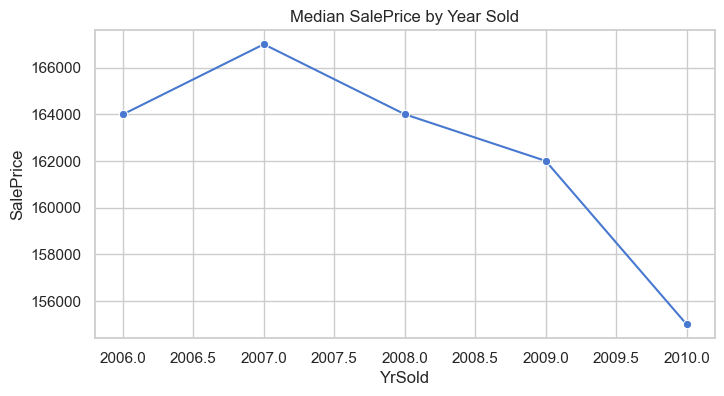

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12840\3236114234.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MoSold', y='SalePrice', data=monthly, palette='Blues_d', ax=ax)


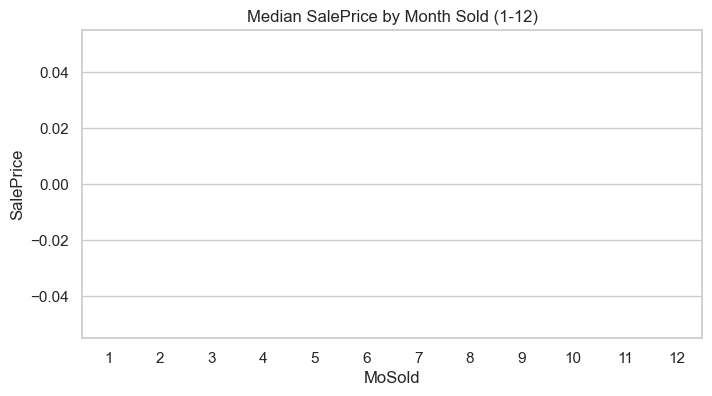

In [35]:
#  Market Trends and Historical Pricing

if 'YrSold' in df.columns and 'SalePrice' in df.columns:
    yearly = df.groupby('YrSold')['SalePrice'].median().reset_index()
    fig, ax = plt.subplots(figsize=(8,4))
    sns.lineplot(data=yearly, x='YrSold', y='SalePrice', marker='o', ax=ax)
    ax.set_title('Median SalePrice by Year Sold')
    plt.show()
    save_fig(fig, "market_trend_median_price_by_year.png")

if 'MoSold' in df.columns and 'SalePrice' in df.columns:
    monthly = df.groupby('MoSold')['SalePrice'].median().reindex(range(1,13)).reset_index()
    fig, ax = plt.subplots(figsize=(8,4))
    sns.barplot(x='MoSold', y='SalePrice', data=monthly, palette='Blues_d', ax=ax)
    ax.set_title('Median SalePrice by Month Sold (1-12)')
    plt.show()
    save_fig(fig, "market_trend_median_price_by_month.png")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12840\3918185539.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Pool', 'Has Pool'])


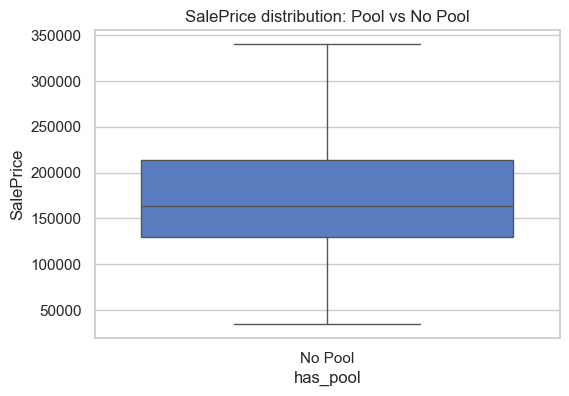


Median SalePrice with pool: nan
Median SalePrice without pool: 163000.0


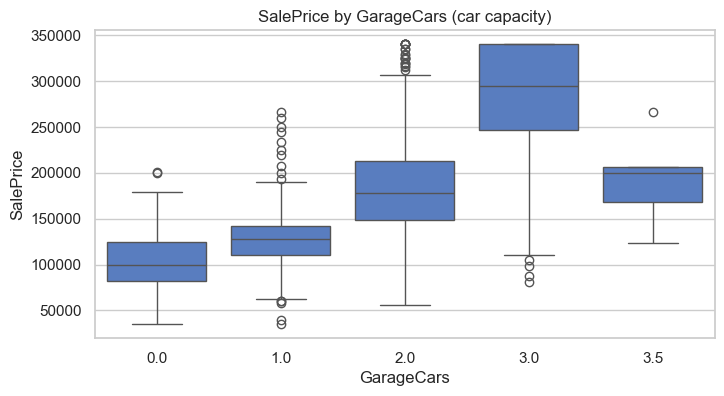

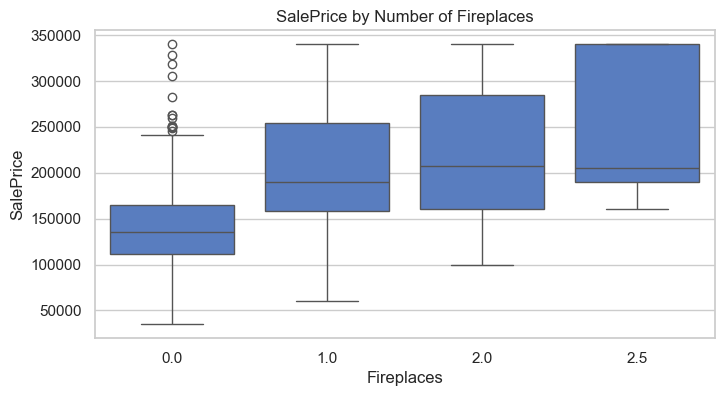


Top 15 neighborhoods by median SalePrice:
 Neighborhood
NridgHt    315000.0
NoRidge    301500.0
StoneBr    278000.0
Timber     228475.0
Somerst    225500.0
Veenker    218000.0
Crawfor    200624.0
ClearCr    200250.0
CollgCr    197200.0
Blmngtn    191000.0
NWAmes     182900.0
Gilbert    181000.0
SawyerW    179900.0
Mitchel    153500.0
NPkVill    146000.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12840\3918185539.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nb.values, y=nb.index, orient='h', palette='Spectral')


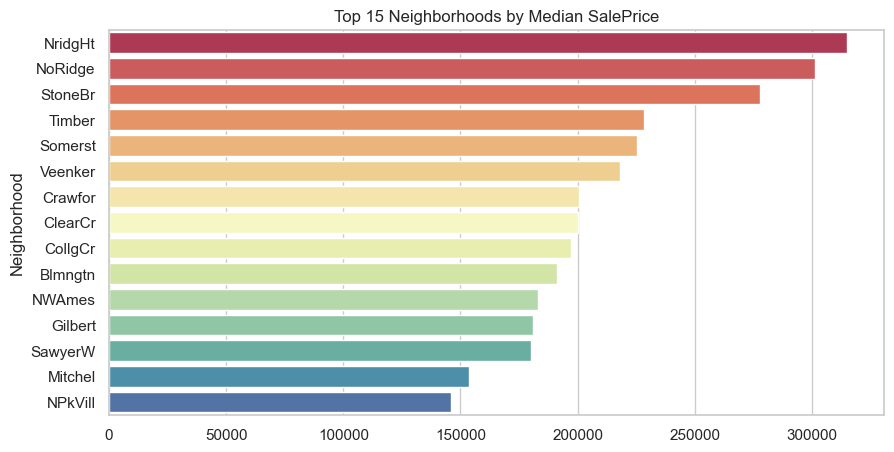

In [36]:
# Customer Preferences and Amenities

if 'PoolArea' in df.columns and 'SalePrice' in df.columns:
    df['has_pool'] = (df['PoolArea'] > 0).astype(int)
    fig, ax = plt.subplots(figsize=(6,4))
    sns.boxplot(x='has_pool', y='SalePrice', data=df, ax=ax)
    ax.set_xticklabels(['No Pool', 'Has Pool'])
    ax.set_title('SalePrice distribution: Pool vs No Pool')
    plt.show()
    save_fig(fig, "amenity_pool_vs_price_box.png")
    print("\nMedian SalePrice with pool:", df[df['has_pool']==1]['SalePrice'].median())
    print("Median SalePrice without pool:", df[df['has_pool']==0]['SalePrice'].median())

if 'GarageCars' in df.columns and 'SalePrice' in df.columns:
    fig, ax = plt.subplots(figsize=(8,4))
    sns.boxplot(x='GarageCars', y='SalePrice', data=df, ax=ax)
    ax.set_title('SalePrice by GarageCars (car capacity)')
    plt.show()
    save_fig(fig, "amenity_garagecars_vs_price.png")

if 'Fireplaces' in df.columns and 'SalePrice' in df.columns:
    fig, ax = plt.subplots(figsize=(8,4))
    sns.boxplot(x='Fireplaces', y='SalePrice', data=df, ax=ax)
    ax.set_title('SalePrice by Number of Fireplaces')
    plt.show()
    save_fig(fig, "amenity_fireplaces_vs_price.png")

if 'Neighborhood' in df.columns and 'SalePrice' in df.columns:
    nb = df.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False).head(15)
    print("\nTop 15 neighborhoods by median SalePrice:\n", nb.to_string())
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(x=nb.values, y=nb.index, orient='h', palette='Spectral')
    ax.set_title('Top 15 Neighborhoods by Median SalePrice')
    plt.show()
    save_fig(fig, "amenity_top15_neighborhoods_by_price.png")

In [23]:
print("\nPlots saved in directory:", PLOT_DIR)
print("Final DataFrame shape:", df.shape)
print("Columns sample:", df.columns[:30].tolist())
print(df.head().to_string())


Plots saved in directory: eda_plots
Final DataFrame shape: (1460, 86)
Columns sample: ['Unnamed: 0', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure']
   Unnamed: 0 MSZoning  LotFrontage  LotArea Street LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHa

In [38]:
FINAL_OUTPUT = "housing_analysis_full_result.csv"


df.to_csv(FINAL_OUTPUT, index=False, encoding='utf-8-sig')

print("\n✅ Final CSV Export Completed Successfully!")
print("FINAL_OUTPUT")



✅ Final CSV Export Completed Successfully!
FINAL_OUTPUT
